In [1]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing store data
Store_file_path = r'D:\Learning\Data\rossmann-store-sales/store.csv'
store = pd.read_csv(Store_file_path)
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
# Importing train data
train_file_path = r'D:\Learning\Data\rossmann-store-sales/train.csv'
train = pd.read_csv(train_file_path, parse_dates = True)
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
train_store_joined = pd.merge(train, store, on='Store', how='inner')
#test_store_joined = pd.merge(test, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


### Exploratory Data Analysis - EDA

__Trend and Seasonality__

In [5]:
# data extraction for analysis
train_store_joined.Date = pd.to_datetime(train_store_joined.Date)
train_store_joined['Year'] = train_store_joined.Date.dt.year
train_store_joined['Month'] = train_store_joined.Date.dt.month
train_store_joined['Day'] = train_store_joined.Date.dt.day
train_store_joined['WeekOfYear'] = train_store_joined.Date.dt.weekofyear

In [6]:
#Assining the date as index
train_store_joined.index = train_store_joined['Date']
train_store_joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
2015-07-30,1,4,2015-07-30,5020,546,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,30,31
2015-07-29,1,3,2015-07-29,4782,523,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,29,31
2015-07-28,1,2,2015-07-28,5011,560,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,28,31
2015-07-27,1,1,2015-07-27,6102,612,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,27,31


In [7]:
# Checking for the dataTypes
train_store_joined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance   

__Observations__
- Data contains features will NAN values 
    - CompetitionOpenSinceMonth
    - CompetitionOpenSinceYear
    - Promo2SinceWeek
    - Promo2SinceYear
    - PromoInterval
- Features are having object dtype    

In [8]:
nan_count = pd.DataFrame(train_store_joined.isnull().sum(), columns=['NAN_Count'])
nan_count['Percentage_NAN'] = (nan_count/train_store_joined.shape[0])*100
nan_count

,NAN_Count,Percentage_NAN
Store,0,0.000000
DayOfWeek,0,0.000000
Date,0,0.000000
Sales,0,0.000000
Customers,0,0.000000
Open,0,0.000000
Promo,0,0.000000
StateHoliday,0,0.000000
SchoolHoliday,0,0.000000
StoreType,0,0.000000


__Obervations__
- CompetitionDistance is a important feature, hence we need handle these missing values.
- CompetitionOpenSinceMonth, CompetitionOpenSinceYear contains approx 32% NAN records.
- Promo2SinceWeek, Promo2SinceYear, PromoInterval featurres are having approx 50% NAN records. 

### Univariant Analysis

__Sales__

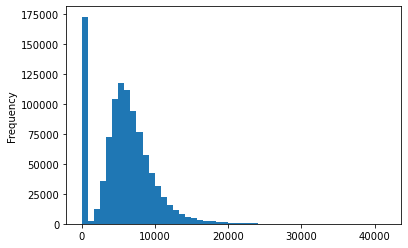

In [9]:
train_store_joined.Sales.plot(kind='hist', bins=50);

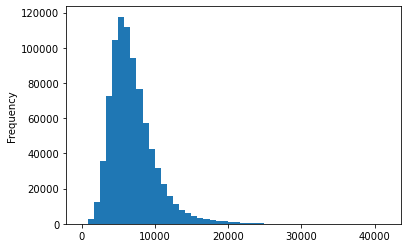

In [10]:
# If the store is close than sale will be zero, hence filtering the closed stores
train_store_joined[(train_store_joined.Open!=0)]['Sales'].plot(kind='hist', bins=50);

In [11]:
train_store_joined = train_store_joined[(train_store_joined.Open!=0)]

In [12]:
train_store_joined[train_store_joined.Sales==0].shape

(54, 22)

__Observations__
- records with Open features as 0 are filtered as they are non significant (store is close)
- There are 54 records with zero sale these records will be dropped during model building

__Customer__

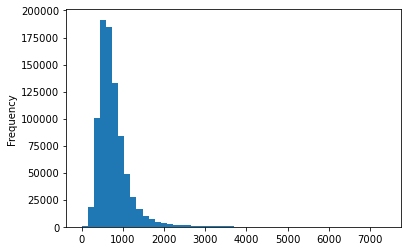

In [13]:
train_store_joined.Customers.plot(kind='hist', bins=50);

In [14]:
train_store_joined[(train_store_joined.Customers==0)].shape

(52, 22)

In [15]:
train_store_joined[(train_store_joined.Customers==0)].groupby(by='StoreType').sum()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear
StoreType,,,,,,,,,,,,,,,,,
a,19401,122,0,0,34,10,9,84840.0,189.0,44195.0,29,406.0,58373.0,68464,192,567,788
b,612,10,0,0,2,1,0,1110.0,0.0,0.0,1,14.0,2013.0,4026,5,23,17
c,5634,37,0,0,10,5,2,29330.0,65.0,18063.0,5,79.0,10064.0,20140,49,113,192
d,3765,25,0,0,6,3,1,28420.0,20.0,8043.0,3,78.0,6035.0,12083,31,79,123


__Observations__
- There are 52 records with customer counts as 0 
- These records can be droped during model building

__StateHoliday__

indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


In [16]:
train_store_joined.StateHoliday.unique()

array(['0', 0, 'a', 'b', 'c'], dtype=object)

In [17]:
StateHoliday_mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1}

In [18]:
train_store_joined['StateHoliday'] = train_store_joined['StateHoliday'].map(StateHoliday_mappings)

In [19]:
train_store_joined.StateHoliday.unique()

array([0, 1], dtype=int64)

__Observations__
- converted all type of holidays as 1
- we can assign high weight to the Easter and Christmas holidays

### Bivariant Analysis

In [20]:
# Adding a new variable 'SalePerCustomer'
train_store_joined['SalePerCustomer'] = train_store_joined.Sales/train_store_joined.Customers

__StoreType__

In [21]:
train_store_joined.StoreType.unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [22]:
train_store_joined.groupby(by='StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457077.0,6925.167661,3277.786381,0.0,4695.0,6285.0,8406.0,41551.0
b,15563.0,10231.407505,5157.190155,0.0,6344.0,9130.0,13183.5,38722.0
c,112978.0,6932.512755,2897.564578,0.0,4915.0,6407.0,8349.0,31448.0
d,258774.0,6822.141881,2556.582881,0.0,5050.0,6395.0,8123.0,38037.0


In [23]:
train_store_joined.groupby(by='StoreType')['SalePerCustomer'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457043.0,8.846277,1.690962,0.000000,7.611940,8.631362,9.899435,29.877551
b,15561.0,5.133097,1.254623,0.000000,4.039384,4.986865,6.108364,9.203528
c,112968.0,8.626227,1.694325,3.382542,7.416985,8.424736,9.643063,64.957854
d,258768.0,11.277862,1.990706,4.881279,9.873309,11.194977,12.560328,57.614983


In [24]:
train_store_joined.groupby(train_store_joined.StoreType)['Sales', 'Customers'].sum()

,Sales,Customers
StoreType,,
a,3165334859,363541434
b,159231395,31465621
c,783221426,92129705
d,1765392943,156904995


In [27]:
# No of store in each storetype 
train_store_joined['StoreCount'] = 1
train_store_joined.groupby(by='StoreType')['StoreCount'].sum()

StoreType
a    457077
b     15563
c    112978
d    258774
Name: StoreCount, dtype: int64

__Observations__
- store type b is having the highest sale mean 
- SalePerCustomer is highest in store type d 
- from total customers and store numer point of view store type a more important

[]

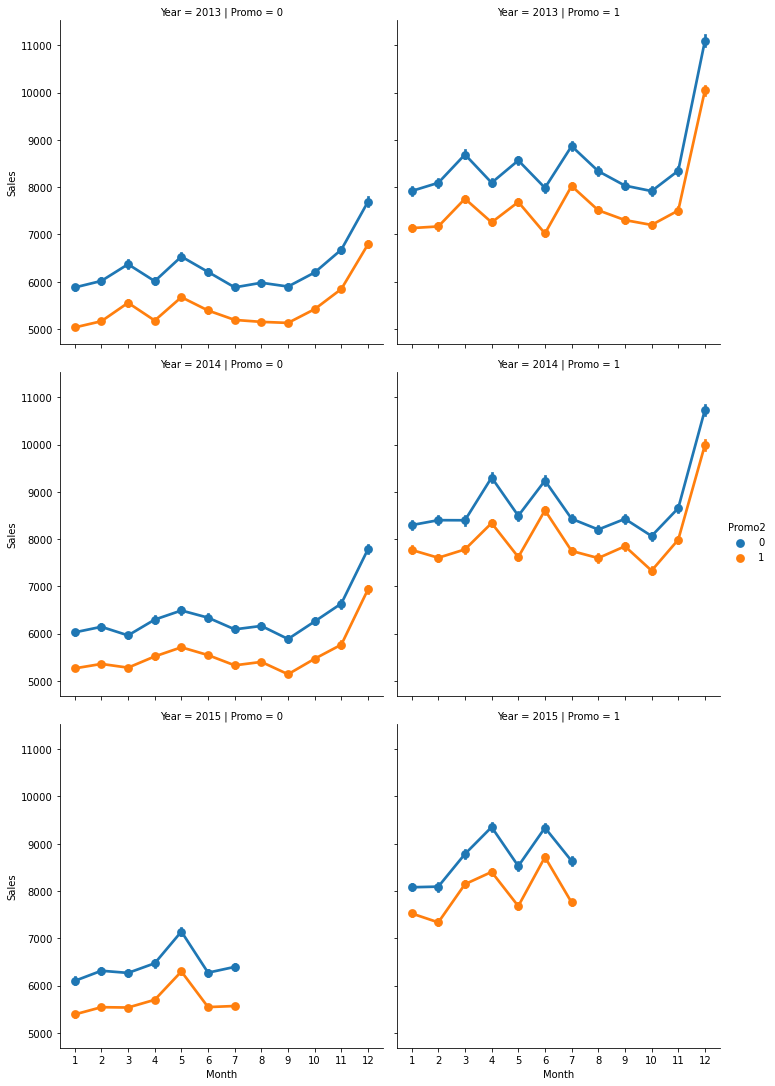

In [95]:
# sales vary with month, promo, promo2 (second promotional offer) and year
# Sales trend over the months and year
sns.factorplot(data = train_store_joined, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year")
plt.plot()

__Observations__
- Sales spkies in the month of December due to the Christmas and New Year holiday seasons 
- This confirms that the sales is varrying with date and having a seasonal effect 

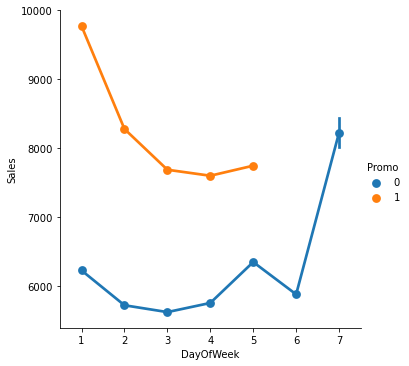

In [96]:
# Sales trend over days
sns.factorplot(data = train_store_joined, x = "DayOfWeek", y = "Sales", hue = "Promo")
plt.show()

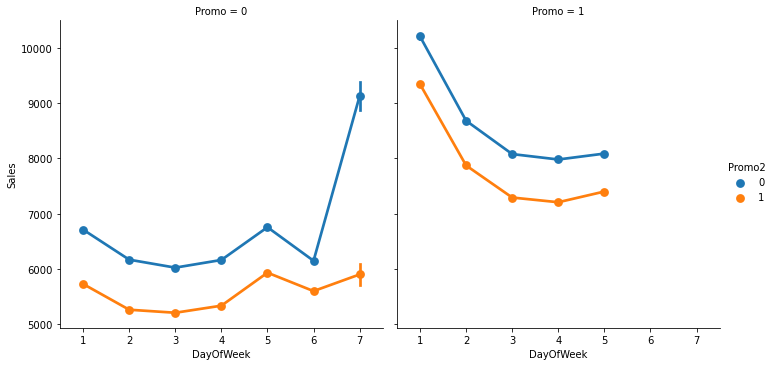

In [101]:
# checking Promo2 
sns.factorplot(data = train_store_joined, x = "DayOfWeek", y = "Sales", hue = "Promo2", col="Promo")
plt.show()

__Observations__
- There is no promotional offers on weekend i.e., Saturday and Sunday (Store wants to gain maximum profit)
- There is sharp increase in the sales on Sunday.
- Maximum sale happens on Monday with promotional offer
- In present of Promo2 overall sale is decreasing

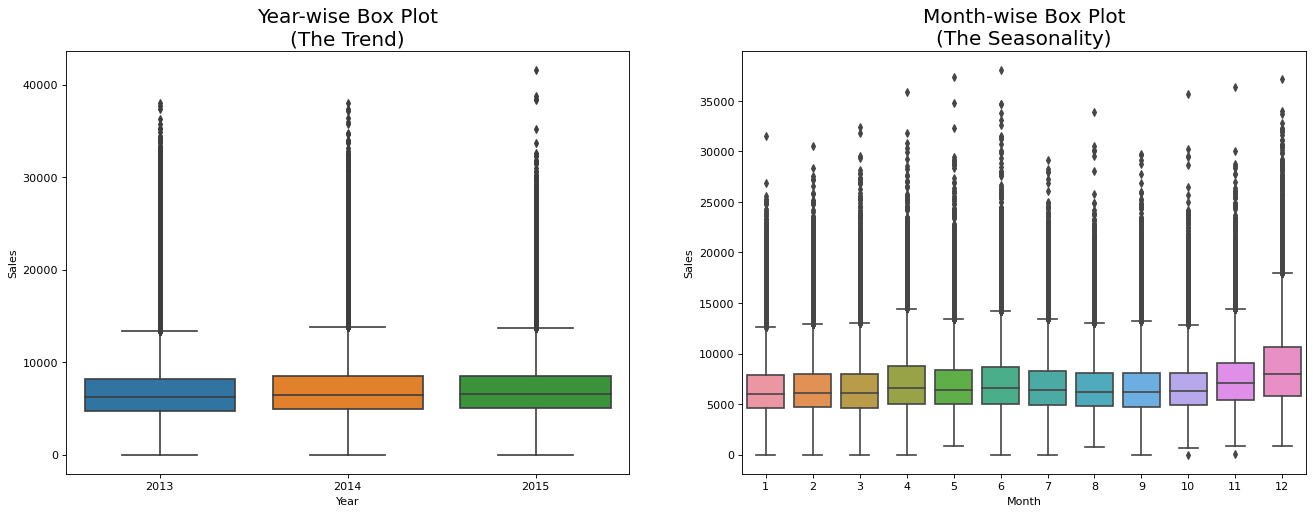

In [126]:
# Draw Box plot for year and month 
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='Sales', data=train_store_joined, ax=axes[0])
sns.boxplot(x='Month', y='Sales', data=train_store_joined.loc[~train_store_joined.Year.isin([2013 ,2015]), :], ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

__Observations__
- There is no significant Trend present in the data
- Weak seasonality is present

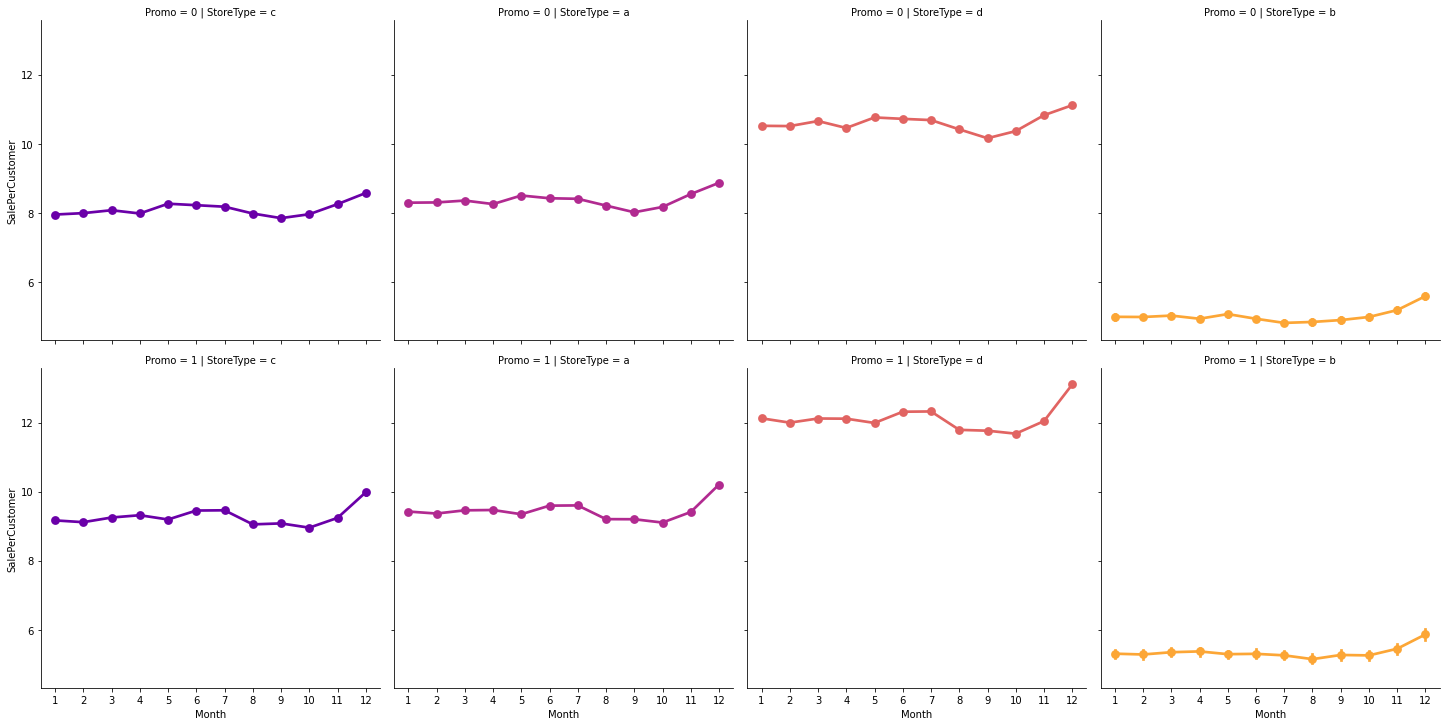

In [99]:
# Month vs SalePerCustomer trend based on Store Type and Promo 
sns.factorplot(data=train_store_joined, x='Month', y='SalePerCustomer', hue='StoreType', col ='StoreType' ,row='Promo', palette = 'plasma');

__Observations__
- Based on the above Month Vs SalesPerCustomer trend, we can conclude that the Store type d is having the highest seeling rate per customer compare to the other store type
- Low sale per customer of Store type b describes its buyer cart. There is a lot of peoples who shop for essentials items only. This Store type generates the least customer and sales as per the above stats.

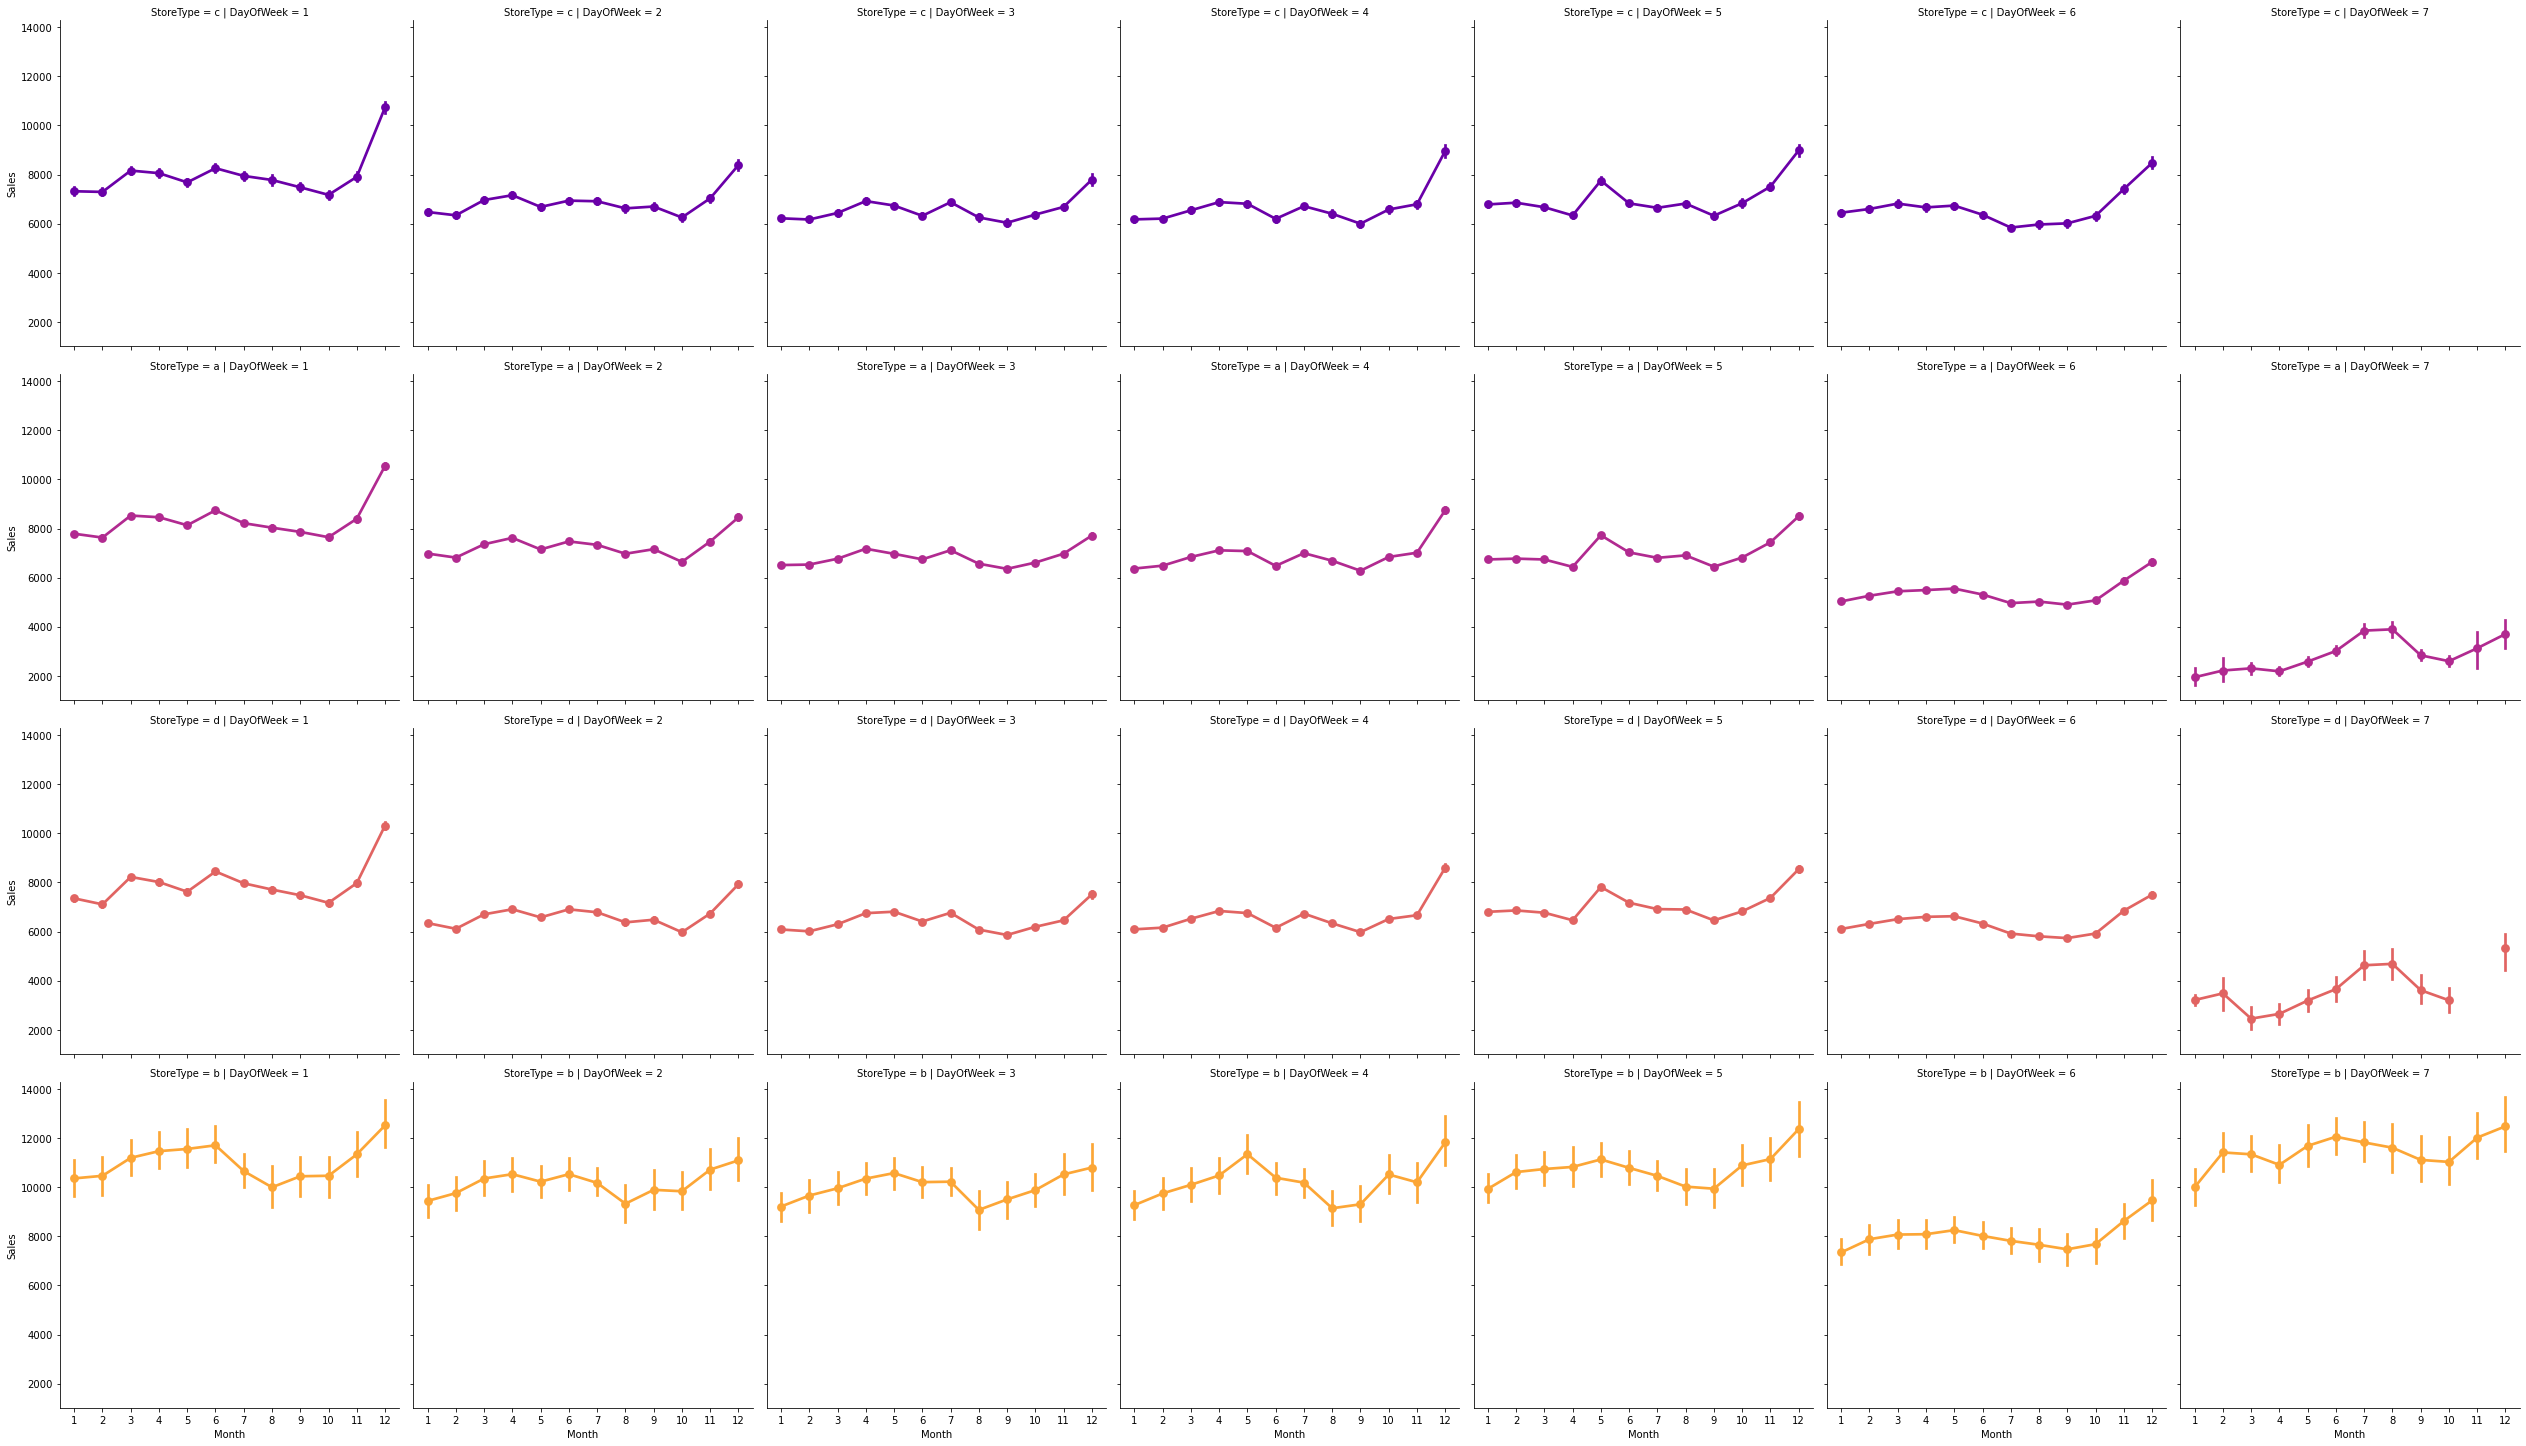

In [100]:
#Month vs Sales trend based on Store Type and Promo 
sns.factorplot(data=train_store_joined, x='Month', y='Sales', hue='StoreType', col ='DayOfWeek' ,row='StoreType', palette = 'plasma');

__Observations__
- Store Type c is closed on Sunday 
- Store Type d is closed on sunday in the month of October to December

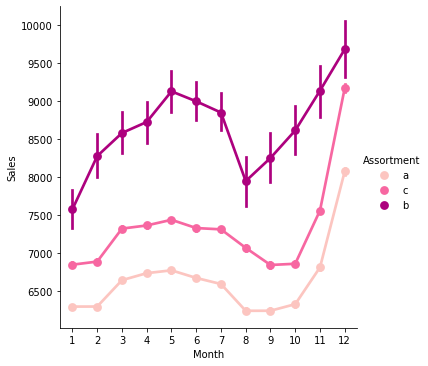

In [104]:
sns.factorplot(data=train_store_joined, x='Month', y='Sales', hue='Assortment', palette ='RdPu');

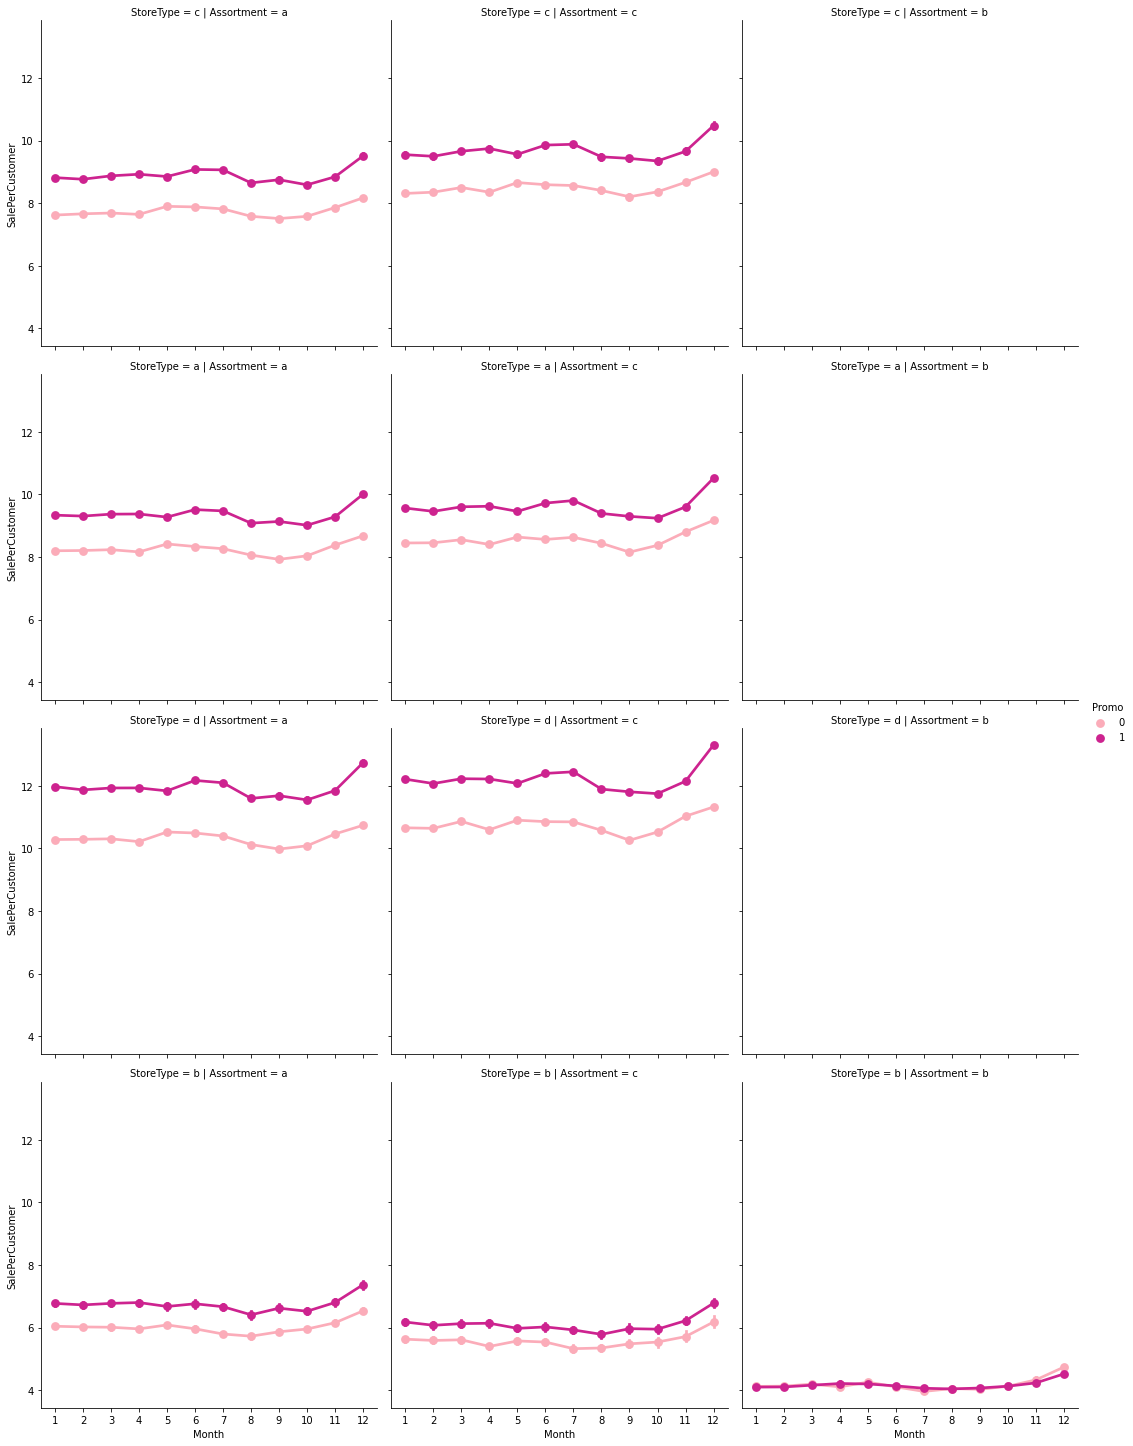

In [105]:
#Month vs Sales trend based on Assortment
sns.factorplot(data=train_store_joined, x='Month', y='SalePerCustomer', hue='Promo', col ='Assortment', row='StoreType' , palette ='RdPu');

__Observations__
- Assortment type b is having least sale per customer, hence there is an area of improvement here.
- Assortment type b is only having store type b 

### Conclusion from EDA
- The most crowded store type is a.
- The best Sale per customer of Store type d indicates the higher buyer cart. To benefit from this fact, company can consider proposing bigger variety of its products.
- Low SalePerCustomer amount for store type b indicates to the possible fact that people shop there essentially for "small" things. Eventhough this store type generated the least amount of sales and customers over the whole period, it shows a great potential.
- Customers tends to buy more on Mondays when there's one promotion (Promo=1) and on Sundays when there's no promotion at all (both Promo and Promo2 are equal to 0).
- Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.

### Handling categorical features (Feature Engineering)

In [28]:
df = train_store_joined.copy()

In [29]:
# converting the store type and assortment into dummy variables
dummy_store_type = pd.get_dummies(df.StoreType, prefix='StoreType' ,drop_first=True)
dummy_assortment = pd.get_dummies(df.Assortment, prefix='Assortment' ,drop_first=True)

# updating the missing values with median
df.CompetitionDistance = df.CompetitionDistance.fillna(df['CompetitionDistance'].median())
df.CompetitionOpenSinceMonth = df.CompetitionOpenSinceMonth.fillna(df['CompetitionOpenSinceMonth'].median())
df.CompetitionOpenSinceYear = df.CompetitionOpenSinceYear.fillna(df['CompetitionOpenSinceYear'].median())

# Coverting Date fetures into a single feature
df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)

In [30]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'SalePerCustomer', 'StoreCount', 'CompetitionOpen'],
      dtype='object')

In [31]:
# Droping the extra columns, Promo2 releated columns are not considered as they are not having significant impact on sale
selected_col = ['Store', 'Sales','DayOfWeek', 'Customers', 'Promo','StateHoliday', 'SchoolHoliday',
                'CompetitionDistance', 'WeekOfYear', 'CompetitionOpen']

In [32]:
df = pd.concat((df[selected_col], dummy_assortment,dummy_store_type), axis=1)

In [33]:
df.head()

,Store,Sales,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,WeekOfYear,CompetitionOpen,Assortment_b,Assortment_c,StoreType_b,StoreType_c,StoreType_d
Date,,,,,,,,,,,,,,,
2015-07-31,1,5263,5,555,1,0,1,1270.0,31,82.0,0,0,0,1,0
2015-07-30,1,5020,4,546,1,0,1,1270.0,31,82.0,0,0,0,1,0
2015-07-29,1,4782,3,523,1,0,1,1270.0,31,82.0,0,0,0,1,0
2015-07-28,1,5011,2,560,1,0,1,1270.0,31,82.0,0,0,0,1,0
2015-07-27,1,6102,1,612,1,0,1,1270.0,31,82.0,0,0,0,1,0


### Stationary check of Time Series Store wise

In [34]:
# defining function to select store 
def store_selection(store_id, df):
    data = df
    store = data[data.Store==store_id].iloc[:,1:]
    return store

In [35]:
# Defining the function to calculate Stationary
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)

In [36]:
# Checking Stationary in each store
store_1 = store_selection(1, df)
store_1.head()

,Sales,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,WeekOfYear,CompetitionOpen,Assortment_b,Assortment_c,StoreType_b,StoreType_c,StoreType_d
Date,,,,,,,,,,,,,,
2015-07-31,5263,5,555,1,0,1,1270.0,31,82.0,0,0,0,1,0
2015-07-30,5020,4,546,1,0,1,1270.0,31,82.0,0,0,0,1,0
2015-07-29,4782,3,523,1,0,1,1270.0,31,82.0,0,0,0,1,0
2015-07-28,5011,2,560,1,0,1,1270.0,31,82.0,0,0,0,1,0
2015-07-27,6102,1,612,1,0,1,1270.0,31,82.0,0,0,0,1,0


In [37]:
test_stationarity(store_1.Sales)

Results of Dickey-Fuller Test:
ADF Statistic: -5.412786
p-value: 0.000003
Critical Values:
1% -3.4389045244994096
5% -2.8653156040031176
10% -2.5687805115003


In [33]:
# Creating an array with p values for all the stores
list_sta = []
for store in train.Store.unique():
    result = adfuller(train[train.Store == store]['Sales'], autolag='AIC')
    list_sta.append(result[1])

In [39]:
# Checking the average mean of probablity to check the Stationary of data
list_sta = pd.Series(list_sta)
list_sta.mean()

0.01167889621448304

__Observation__
- Mean p value is 0.01167
- P Value greater > 0.05 indicates data is Stationary 
- Series is slightly Non-Stationary, hence we are proceeding with same data

### Seasonality and Trend 

In [111]:
def plot_timeseries(sales):
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    decomposition= seasonal_decompose(sales.dropna(), model = 'add',freq=365)
    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid

    axes[1].plot(estimated_seasonal, 'g', label='add')
    axes[1].legend(loc='upper left');

    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');
    plt.title('Decomposition Plots')
    
#     axes[2].plot(estimated_residual, label='Residual')
#     axes[2].legend(loc='upper left');
#     plt.title('Decomposition Plots')

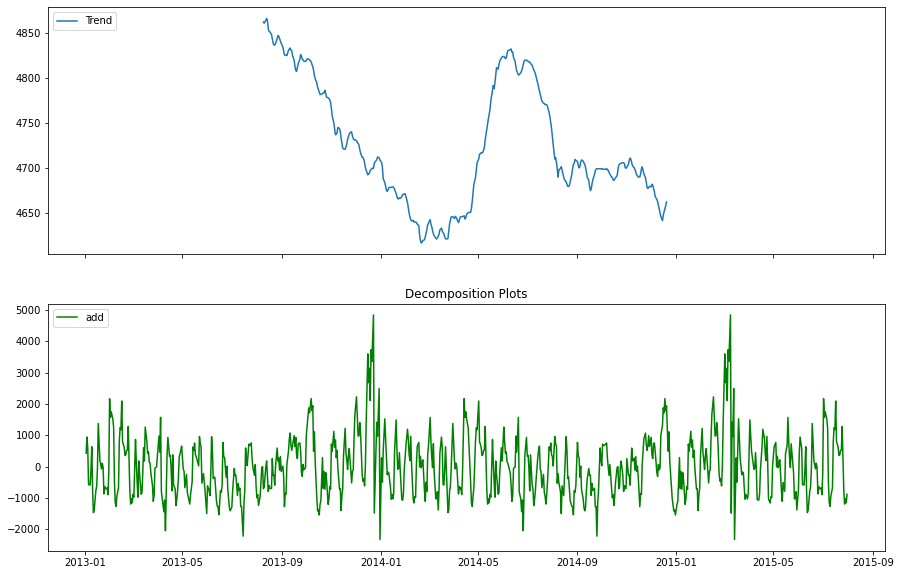

In [112]:
plot_timeseries(store_1.Sales)

__Observations__
- Seasonality and trend is available in the data

## Models

### ARIMA

In [169]:
# Store_selection
store_1 =store_selection(1, df)

In [172]:
# Train, Test split on the sample data
store_1.index = store_1.index.sort_values(ascending=True)
train_arima = store_1[:len(store_1)-30]
test_arima = store_1[len(store_1)-30:]

In [127]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_arima['Sales'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=11889.859, Time=2.09 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=12558.453, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=12035.463, Time=0.88 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=12068.922, Time=1.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=12556.523, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=12213.649, Time=0.18 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=3.27 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=5.41 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=12027.310, Time=1.28 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=11895.345, Time=6.52 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=11892.651, Time=1.73 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=11877.942, Time=3.80 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=12198.928, Time=0.38 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=3.86 sec
 ARIMA(2,0,1)(0,1,2)[12

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  751
Model:             SARIMAX(3, 0, 3)x(0, 1, [1], 12)   Log Likelihood               -5914.980
Date:                              Fri, 28 Jan 2022   AIC                          11845.960
Time:                                      22:40:51   BIC                          11882.802
Sample:                                           0   HQIC                         11860.166
                                              - 751                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1942      0.217     -0.895      0.371      -0.620       0.231
ar.L2          0.4906      0.070      7.004      0.000       0.353       0.628
ar.L3          0.2091      0.129      1.617      0.106      -0.044       0.462
ma.L1          0.8795      0.224      3.931      0.000       0.441       1.318
ma.L2          0.1658      0.221      0.751      0.453      -0.267       0.598
ma.L3         -0.2149      0.068     -3.149      0.002      -0.349      -0.081
ma.S.L12      -0.8555      0.022    -38.984      0.000      -0.899      -0.813
sigma2      5.128e+05   1.81e+04     28.313      0.000    4.77e+05    5.48e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1017.12
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.94
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [174]:
result = smodel.fit(train_arima['Sales'])

In [175]:
forecast=result.predict(n_periods=len(test_arima))

In [176]:
test_arima = pd.DataFrame(test_arima)
test_arima['Forecast'] = forecast

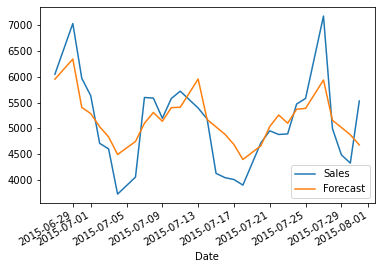

In [178]:
test_arima[['Sales', 'Forecast']].plot();

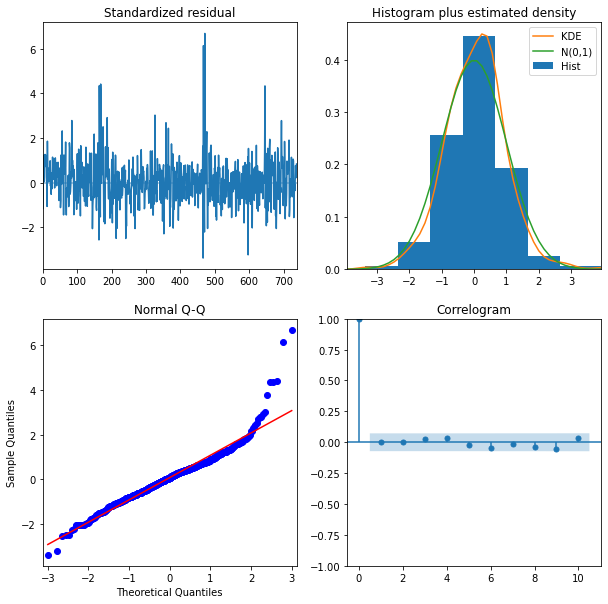

In [179]:
result.plot_diagnostics(figsize=(10, 10))
plt.show()

In [180]:
# Calculating the error
# Root Mean squre is preffered as it penalise the large errors.
rms_arima = sqrt(mean_squared_error(test_arima.Sales, test_arima.Forecast))
print("Root Mean Squared Error: ", rms_arima)

Root Mean Squared Error:  524.4710568060808


In [184]:
# passing the other important features along with sales to the mode
extra_features= train_arima.drop('Sales', axis=1)

In [185]:
# Seasonal - fit stepwise auto-ARIMA
smodel1 = pm.auto_arima(train_arima['Sales'], start_p=1, start_q=1,
                         test='adf',exogenous=extra_features,
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
smodel1.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=10808.626, Time=1.61 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,1,0)[12]          
Total fit time: 1.640 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  751
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood               -5390.313
Date:                  Fri, 28 Jan 2022   AIC                          10808.626
Time:                          23:05:22   BIC                          10873.100
Sample:                               0   HQIC                         10833.486
                                  - 751                                         
Covariance Type:                    opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
DayOfWeek             -16.8383      9.262     -1.818      0.069     -34.991       1.315
Customers               9.7676      0.119     82.304      0.000       9.535      10.000
Promo                 428.9237     30.757     13.945      0.000     368.640     489.207
StateHoliday        -6.215e-14   2.69e-11     -0.002      0.998   -5.28e-11    5.26e-11
SchoolHoliday          52.7945     26.937      1.960      0.050      -0.001     105.590
CompetitionDistance  5.427e-08   3.52e-11   1541.192      0.000    5.42e-08    5.43e-08
WeekOfYear              2.2281      1.398      1.594      0.111      -0.511       4.968
CompetitionOpen       -29.4195     19.128     -1.538      0.124     -66.909       8.070
Assortment_b                 0         -0        nan        nan           0           0
Assortment_c                 0         -0        nan        nan           0           0
StoreType_b                  0         -0        nan        nan           0           0
StoreType_c          1.263e-06         -0       -inf      0.000    1.26e-06    1.26e-06
StoreType_d                  0         -0        nan        nan           0           0
sigma2               1.268e+05   6097.648     20.793      0.000    1.15e+05    1.39e+05
===================================================================================
Ljung-Box (L1) (Q):                  18.14   Jarque-Bera (JB):                 6.68
Prob(Q):                              0.00   Prob(JB):                         0.04
Heteroskedasticity (H):               1.04   Skew:                            -0.15
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [197]:
result = smodel1.fit(train_arima['Sales'], exogenous=extra_features)
forecast=result.predict(n_periods=len(test_arima), exogenous=test_arima.drop('Sales', axis=1))

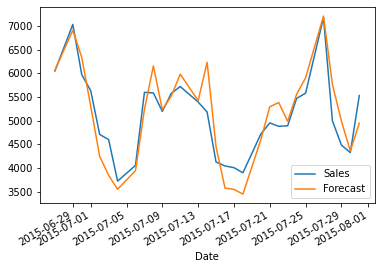

In [198]:
test_arima = pd.DataFrame(test_arima)
test_arima['Forecast'] = forecast

#Ploting
test_arima[['Sales', 'Forecast']].plot();

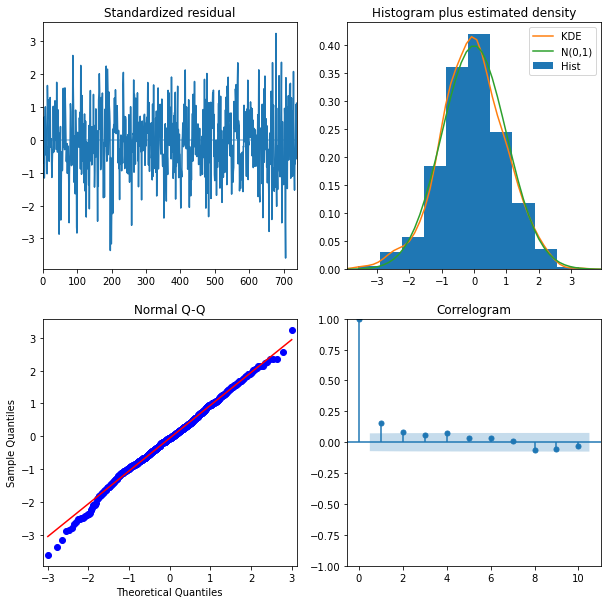

In [235]:
result.plot_diagnostics(figsize=(10, 10))
plt.show()

In [199]:
# Calculating the error
# Root Mean squre is preffered as it penalise the large errors.
rms_arima = sqrt(mean_squared_error(test_arima.Sales, test_arima.Forecast))
print("Root Mean Squared Error: ", rms_arima)

Root Mean Squared Error:  414.0418602002832


__Obervations__
- SARIMA is having Root mean squre value : 524.47
- SARIMAX is having Root mean square value : 414.04
- Here SARIMAX is performing better

### XGBOOST

In [38]:
#Selecting the Store
store_xgboost = store_selection(1, df)
store_xgboost.head()

,Sales,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,WeekOfYear,CompetitionOpen,Assortment_b,Assortment_c,StoreType_b,StoreType_c,StoreType_d
Date,,,,,,,,,,,,,,
2015-07-31,5263,5,555,1,0,1,1270.0,31,82.0,0,0,0,1,0
2015-07-30,5020,4,546,1,0,1,1270.0,31,82.0,0,0,0,1,0
2015-07-29,4782,3,523,1,0,1,1270.0,31,82.0,0,0,0,1,0
2015-07-28,5011,2,560,1,0,1,1270.0,31,82.0,0,0,0,1,0
2015-07-27,6102,1,612,1,0,1,1270.0,31,82.0,0,0,0,1,0


In [39]:
# Splitting the data
features = store_xgboost.drop(["Sales"], axis = 1)
target = pd.DataFrame(store_xgboost["Sales"])

X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20)
y_train.head()

,Sales
Date,
2013-06-28,4407
2015-04-29,5775
2015-04-17,4718
2014-07-16,5424
2013-09-19,3717


In [40]:
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost

In [41]:
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [42]:
# Defining time function to calculate the time 
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [43]:
classifier=xgboost.XGBRegressor()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)

In [44]:
from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train,y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits

 Time taken: 0 hours 0 minutes and 4.64 seconds.


In [45]:
best_model = random_search.best_estimator_

In [46]:
predict_val = best_model.predict(X_test)

In [47]:
sqrt(mean_squared_error(y_test, predict_val))

361.0640255335489

In [48]:
test_xgboost = pd.DataFrame(y_test)
test_xgboost['Predicated Sales'] = predict_val
test_xgboost.head()

,Sales,Predicated Sales
Date,,
2015-05-18,5280,5502.888672
2014-07-22,3933,3726.514648
2014-01-27,3601,4090.119141
2015-06-26,3317,3634.363525
2014-04-23,3482,3644.427002


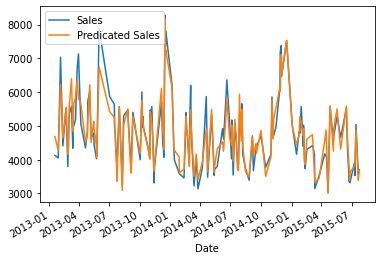

In [49]:
test_xgboost.plot();

__Observations__
- Square root error for XGBOOST is 361.06
- Square root error for SARIMAX is 414.04
- We will select the SARIMAX model for the forecasting